In [29]:
# Clear all variables
%reset -f
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import nnwosd as wosd
import pickle
import seaborn as sns
import pandas as pd

def fit_nn_model(x_tensor, y, hidden_sizes=[32,16], activation_fun=wosd.FlippedLeakRELU(alpha=0.08),
                 sigma_v=0.188, sigma_u=0.13, lr=0.01, epochs=1200, bootstrap=False, random_state=None, bootstrap_id=0):
    """
    Fit a neural network to the data with optional bootstrap sampling.

    Parameters:
        x_tensor (torch.Tensor): Input features (n_samples x n_features)
        y (torch.Tensor): Output target (n_samples x 1)
        hidden_sizes (list): Hidden layer sizes
        activation_fun (nn.Module): Activation function
        sigma_v (float): Initial sigma_v for GaussianNLLLoss
        sigma_u (float): Initial sigma_u for GaussianNLLLoss
        lr (float): Learning rate for Adam optimizer
        epochs (int): Number of training epochs
        bootstrap (bool): If True, sample with replacement for training
        random_state (int): Random seed for reproducibility

    Returns:
        dict: Dictionary containing trained model, scalers, predictions, and loss history
    """
    if random_state is not None:
        np.random.seed(random_state + bootstrap_id)
        torch.manual_seed(random_state + bootstrap_id)

    # Bootstrap sampling
    if bootstrap:
        n_samples = x_tensor.shape[0]
        rng = np.random.RandomState(random_state + bootstrap_id if random_state is not None else None)
        indices = rng.choice(n_samples, n_samples, replace=True)
        x_tensor_train = x_tensor[indices]
        y_train = y[indices]

        # print("\n[BOOTSTRAP SAMPLE]")
        # print("Indices:", indices)

        
    else:
        x_tensor_train = x_tensor
        y_train = y

    # Standardize input and output
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_standardized = torch.tensor(scaler_X.fit_transform(x_tensor_train), dtype=torch.float32)
    y_standardized = torch.tensor(scaler_y.fit_transform(y_train), dtype=torch.float32)

    input_size = x_tensor.shape[1]
    output_size = 1

    # Instantiate model and NLL loss
    model = wosd.MLP(input_size, hidden_sizes, output_size, activation_func=activation_fun)
    nll_loss = wosd.GaussianNLLLoss(sigma_v=sigma_v, sigma_u=sigma_u)

    optimizer = optim.Adam(list(model.parameters()) + [nll_loss.log_std_v, nll_loss.log_std_u], lr=lr)

    best_loss = float('inf')
    best_model_state = None
    loss_values = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(X_standardized)
        loss = nll_loss(y_pred, y_standardized)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():  # Turn off gradients temporarily
            for layer in model.layers:
                layer.weight.data.clamp_(min=0)  # Clamp weights to be >= 0
            model.output.weight.clamp_(min=0)  # Set min to 0 to make all weights >= 0

        loss_values.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict()
        

        # if (epoch + 1) % 50 == 0:
        #     print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, '
        #           f'Log-Std(V): {nll_loss.log_std_v.item():.4f}, '
        #           f'Log-Std(U): {nll_loss.log_std_u.item():.4f}')

    # Load best model
    model.load_state_dict(best_model_state)

    # Make predictions
    with torch.no_grad():
        std_v_est = torch.exp(nll_loss.log_std_v).item()
        std_u_est = torch.exp(nll_loss.log_std_u).item()
        y_pred_best = model(X_standardized) + np.sqrt(2/np.pi) * std_u_est
        y_pred_original = scaler_y.inverse_transform(y_pred_best.numpy())

    return {
        'model': model,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'y_pred_original': y_pred_original,
        'loss_values': loss_values,
        'std_v_est': std_v_est,
        'std_u_est': std_u_est,
        'log_std_v':nll_loss.log_std_v,
        'log_std_u':nll_loss.log_std_u
    }

def partial_dependence(model, X, std_u_est,feature_idx, grid_points=50):
    """
    Compute partial dependence for a single feature.
    """
    feature_values = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), grid_points)
    pdp = np.zeros(grid_points)
    X_copy = X.copy()
    
    for i, val in enumerate(feature_values):
        X_copy[:, feature_idx] = val  # Fix the feature value
        inputs = torch.tensor(X_copy, dtype=torch.float32)
        with torch.no_grad():
            preds = model(inputs).numpy()+ np.sqrt(2/np.pi)*std_u_est
        pdp[i] = preds.mean()  # Average predictions across all samples

    return feature_values, pdp


with open('rice92_data.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

# loaded_dict

x1= torch.tensor(np.log(np.array(loaded_dict['AREA']))).reshape(-1,1)
x2= torch.tensor(np.log(np.array(loaded_dict['LABOR']))).reshape(-1,1)
x3= torch.tensor(np.log(np.array(loaded_dict['NPK']))).reshape(-1,1)
x_tensor = torch.cat((x1,x2,x3), dim=1)
y = torch.tensor(np.log(np.array(loaded_dict['PROD']))).reshape(-1,1)

results = fit_nn_model(
    x_tensor, 
    y, 
    hidden_sizes=[32,16], 
    activation_fun=wosd.FlippedLeakRELU(alpha=0.08), 
    sigma_v=0.188, 
    sigma_u=0.13, 
    lr=0.01, 
    epochs=1000, 
    bootstrap=False,
    random_state=42
)

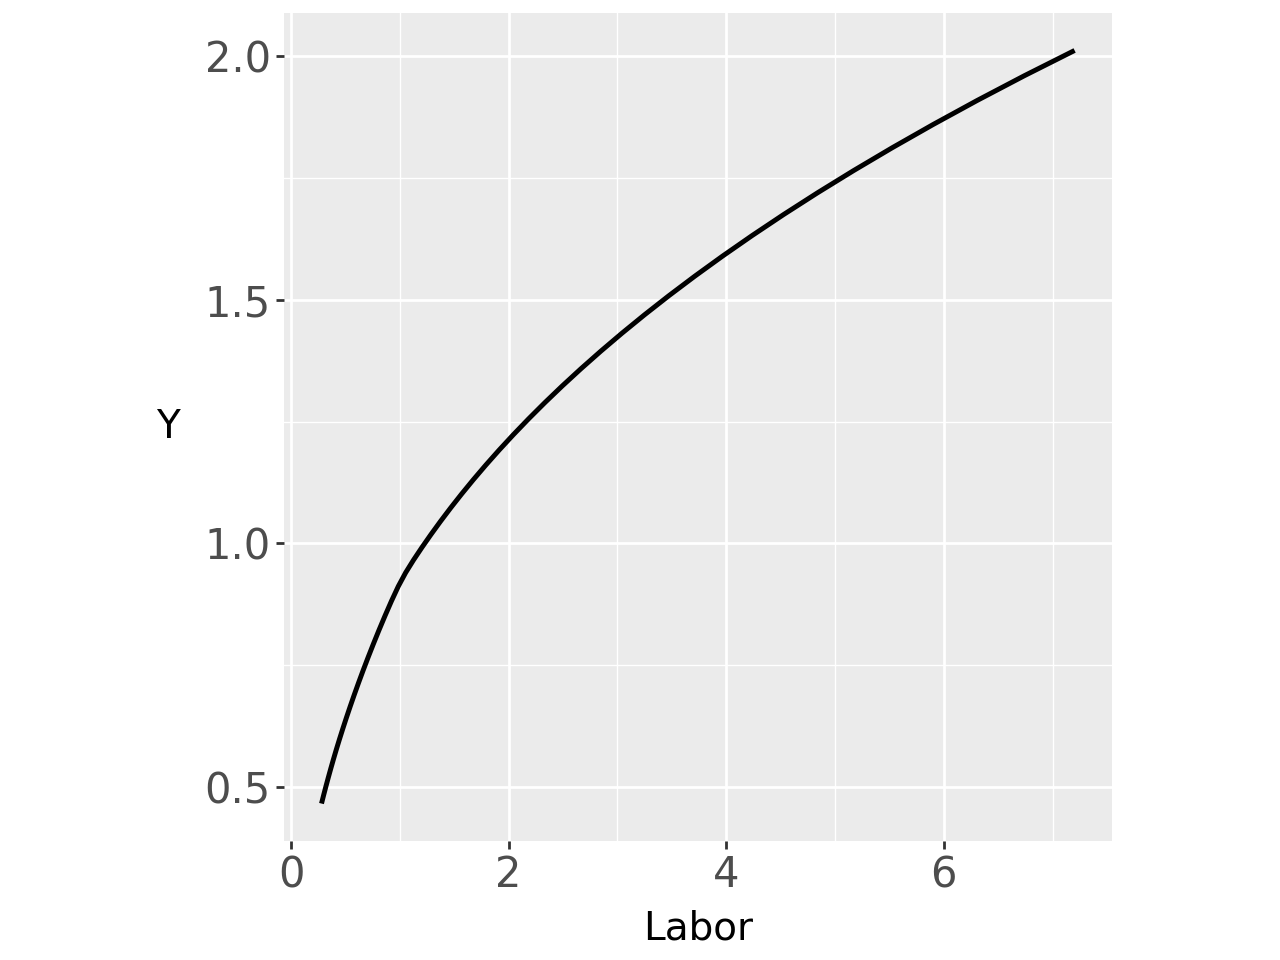

In [30]:
# Step 5: Compute and plot the partial dependence for feature 0
X_Pt = results['scaler_X'].fit_transform(x_tensor)
feature_idx = 1  # Feature index to analyze

# Correctly unpack feature_values and pdp values
feature_values, pdp_values = partial_dependence(
    results['model'],
    X=X_Pt,
    std_u_est=results['std_u_est'],
    feature_idx=feature_idx,
    grid_points=50
)

# Convert to original scale and create DataFrame
pdp_df = pd.DataFrame({
    'Labor': np.exp(feature_values.ravel() * np.std(x1.numpy()) + np.mean(x1.numpy())),
    'Partial Dependence': np.exp(pdp_values.ravel())
})

from plotnine import ggplot, aes, geom_line, labs, theme, element_text

# Create the plot
plot = (
    ggplot() + 
    geom_line(aes(x='Labor', y='Partial Dependence'), data=pdp_df, size=1) +
    labs(x='Labor', y='Y') +
    theme(
        legend_position=(0.97, 0.1),
        aspect_ratio=1,
        legend_title=element_text(size=10, weight='bold'),  
        legend_text=element_text(size=16),
        axis_text=element_text(size=15),
        axis_title=element_text(size=28),
        axis_title_y=element_text(angle=0, size=14, vjust=0.5, hjust=10),
        axis_title_x=element_text(size=14)
    )
)

plot.show()


In [31]:
def partial_dependence_ci(x_tensor, y, feature_idx, B=50, grid_points=50, random_state=42, **fit_kwargs):
    """
    Compute PDP and CI band using bootstrap.
    
    Returns:
        feature_values: grid points for the feature
        pdp_mean: mean PDP across bootstrap samples
        pdp_lower: lower CI (2.5 percentile)
        pdp_upper: upper CI (97.5 percentile)
    """
    n_samples = x_tensor.shape[0]
    pdp_boot = np.zeros((B, grid_points))
    
    # Standardize X for PDP calculation later
    scaler_X = StandardScaler()
    X_standardized = scaler_X.fit_transform(x_tensor)
    
    for b in range(B):
        results_boot = fit_nn_model(
            x_tensor, y, bootstrap=True, random_state=random_state, bootstrap_id=b, **fit_kwargs
        )
        
        feature_values, pdp_values = partial_dependence(
            results_boot['model'],
            X=X_standardized,
            std_u_est=results_boot['std_u_est'],
            feature_idx=feature_idx,
            grid_points=grid_points
        )
        
        pdp_boot[b, :] = pdp_values
       # Print progress every 20 iterations
        if (b + 1) % 20 == 0:
            print(f"Bootstrap iteration {b + 1}/{B} completed.")
    pdp_mean = pdp_boot.mean(axis=0)
    pdp_lower = np.percentile(pdp_boot, 2.5, axis=0)
    pdp_upper = np.percentile(pdp_boot, 97.5, axis=0)
    
    return feature_values, pdp_mean, pdp_lower, pdp_upper


In [32]:
feature_idx = 0  # Feature: AREA
feature_values, pdp_mean, pdp_lower, pdp_upper = partial_dependence_ci(
    x_tensor, y, feature_idx=feature_idx, B=100,
    hidden_sizes=[32,16], activation_fun=wosd.FlippedLeakRELU(alpha=0.08),
    sigma_v=0.188, sigma_u=0.13, lr=0.01, epochs=1000
)

# Convert feature and PDP back to original scale
x0_mean, x0_std = np.mean(np.log(np.array(loaded_dict['AREA']))), np.std(np.log(np.array(loaded_dict['AREA'])))
feature_original = np.exp(feature_values * x0_std + x0_mean)

pdp_mean_exp = np.exp(pdp_mean)
pdp_lower_exp = np.exp(pdp_lower)
pdp_upper_exp = np.exp(pdp_upper)

pdp_df = pd.DataFrame({
    'Area': feature_original,
    'PDP_Mean': pdp_mean_exp,
    'PDP_Lower': pdp_lower_exp,
    'PDP_Upper': pdp_upper_exp
})



Bootstrap iteration 20/100 completed.
Bootstrap iteration 40/100 completed.
Bootstrap iteration 60/100 completed.
Bootstrap iteration 80/100 completed.
Bootstrap iteration 100/100 completed.


NameError: name 'geom_ribbon' is not defined

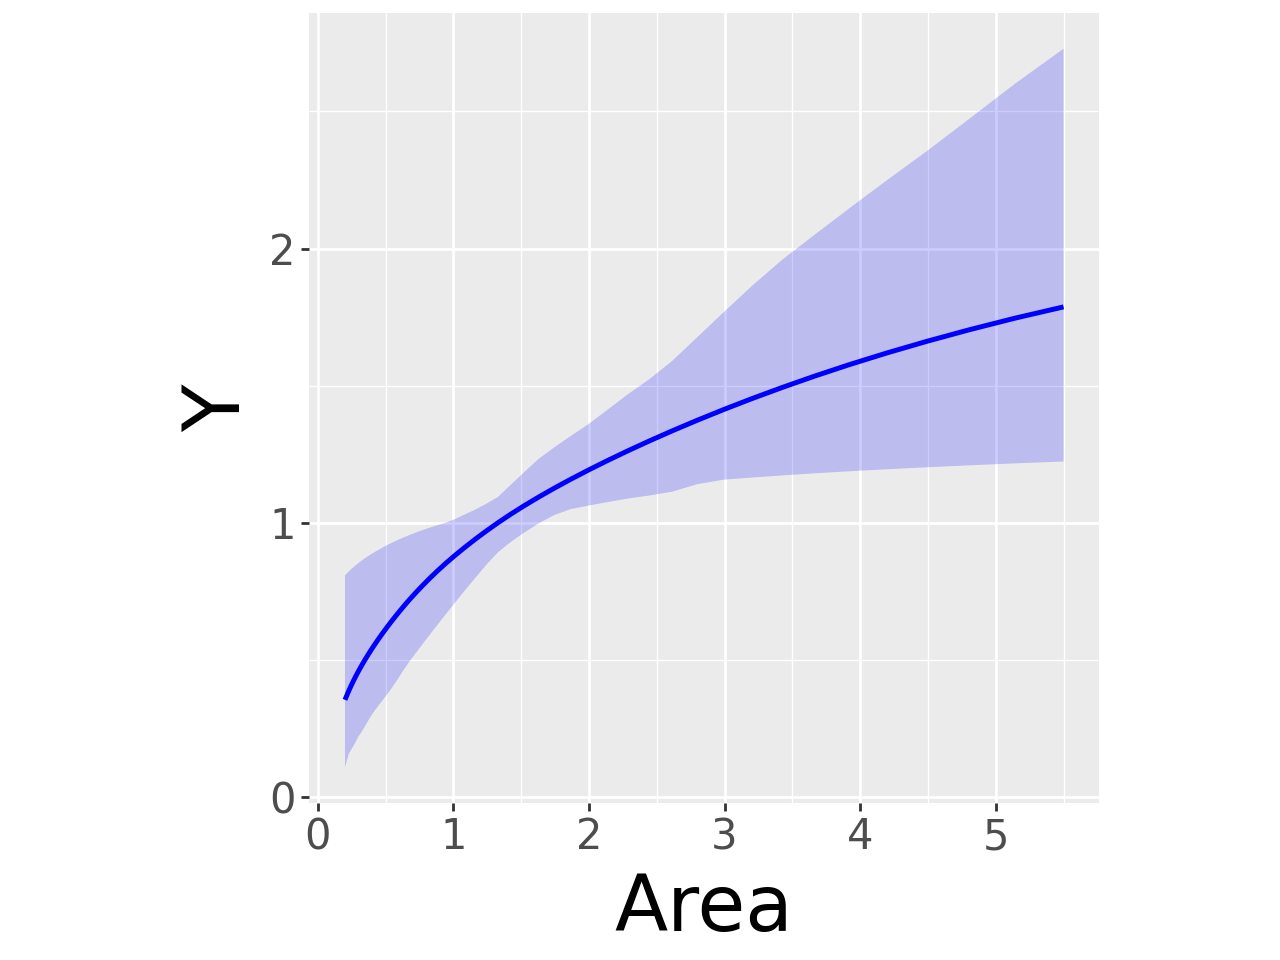

/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: Area_PDP_CI_NNfit_CELU.png


In [34]:
from plotnine import (
    ggplot, aes, geom_line, geom_ribbon,
    labs, theme, element_text
)

plot_area = (
    ggplot(pdp_df) +
    geom_line(aes(x='Area', y='PDP_Mean'), size=1, color='blue') +
    geom_ribbon(aes(x='Area', ymin='PDP_Lower', ymax='PDP_Upper'), alpha=0.2, fill='blue') +
    labs(x='Area', y='Y') +
    theme(
        legend_position=(0.97, 0.1),
        aspect_ratio=1,
        axis_text=element_text(size=15),
        axis_title=element_text(size=28)
    )
)
plot_area.show()


plot_area.save("Area_PDP_CI_NNfit_CELU.png", width=8, height=6, dpi=300)

Bootstrap iteration 20/100 completed.
Bootstrap iteration 40/100 completed.
Bootstrap iteration 60/100 completed.
Bootstrap iteration 80/100 completed.
Bootstrap iteration 100/100 completed.


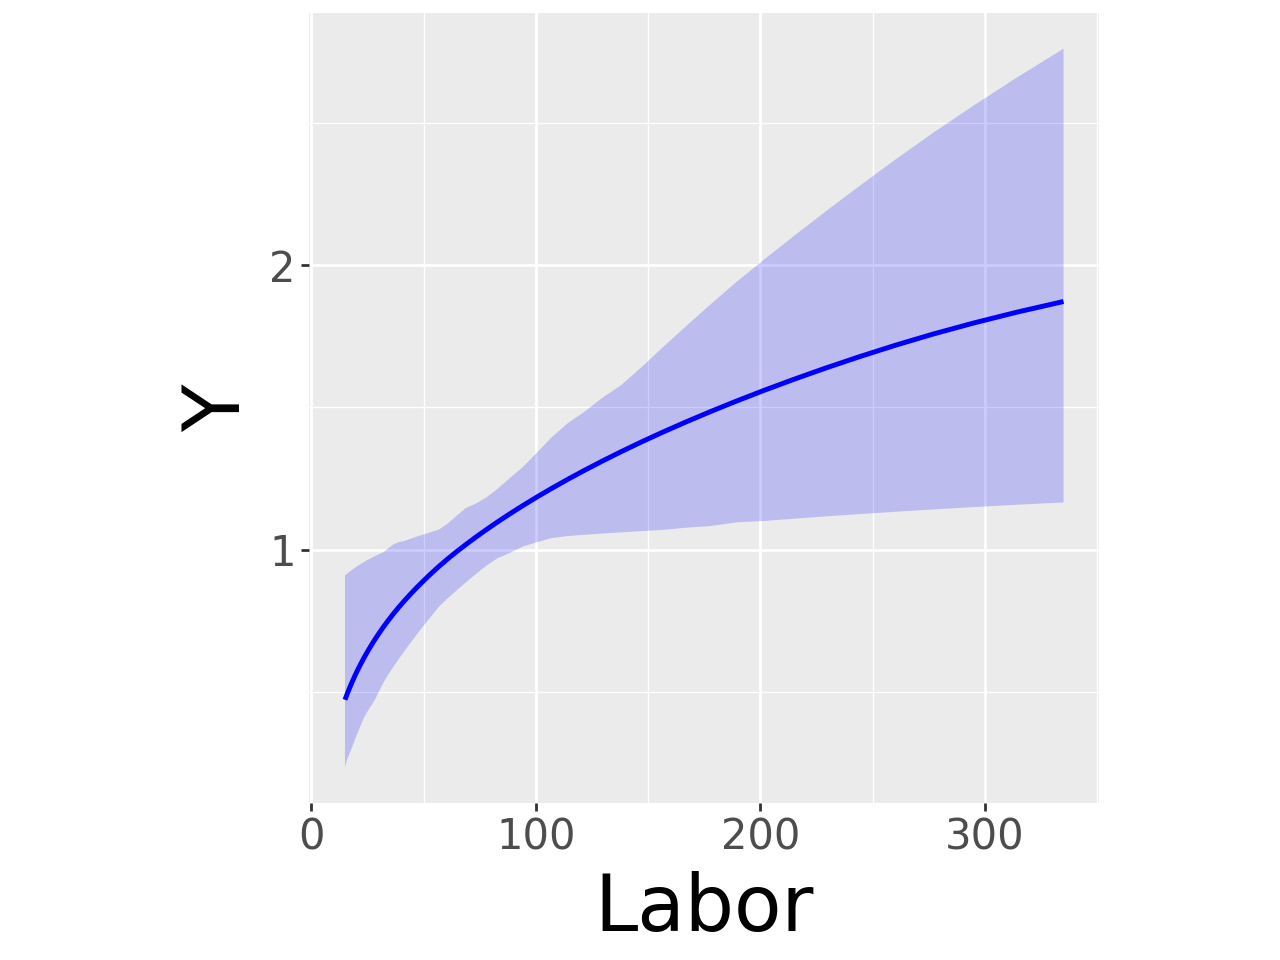

/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: Labor_PDP_CI_NNfit_CELU.png


In [35]:
feature_idx = 1  # Example: Labor
feature_values, pdp_mean, pdp_lower, pdp_upper = partial_dependence_ci(
    x_tensor, y, feature_idx=feature_idx, B=100,
    hidden_sizes=[32,16], activation_fun=wosd.FlippedLeakRELU(alpha=0.08),
    sigma_v=0.188, sigma_u=0.13, lr=0.01, epochs=1000
)

# Convert feature and PDP back to original scale
x1_mean, x1_std = np.mean(np.log(np.array(loaded_dict['LABOR']))), np.std(np.log(np.array(loaded_dict['LABOR'])))
feature_original = np.exp(feature_values * x1_std + x1_mean)

pdp_mean_exp = np.exp(pdp_mean)
pdp_lower_exp = np.exp(pdp_lower)
pdp_upper_exp = np.exp(pdp_upper)

pdp_df = pd.DataFrame({
    'Labor': feature_original,
    'PDP_Mean': pdp_mean_exp,
    'PDP_Lower': pdp_lower_exp,
    'PDP_Upper': pdp_upper_exp
})

from plotnine import ggplot, aes, geom_line, geom_ribbon, labs, theme, element_text

plot_labor = (
    ggplot(pdp_df) +
    geom_line(aes(x='Labor', y='PDP_Mean'), size=1, color='blue') +
    geom_ribbon(aes(x='Labor', ymin='PDP_Lower', ymax='PDP_Upper'), alpha=0.2, fill='blue') +
    labs(x='Labor', y='Y') +
    theme(
        legend_position=(0.97, 0.1),
        aspect_ratio=1,
        axis_text=element_text(size=15),
        axis_title=element_text(size=28)
    )
)
plot_labor.show()
plot_labor.save("Labor_PDP_CI_NNfit_CELU.png", width=8, height=6, dpi=300)

Bootstrap iteration 20/100 completed.
Bootstrap iteration 40/100 completed.
Bootstrap iteration 60/100 completed.
Bootstrap iteration 80/100 completed.
Bootstrap iteration 100/100 completed.


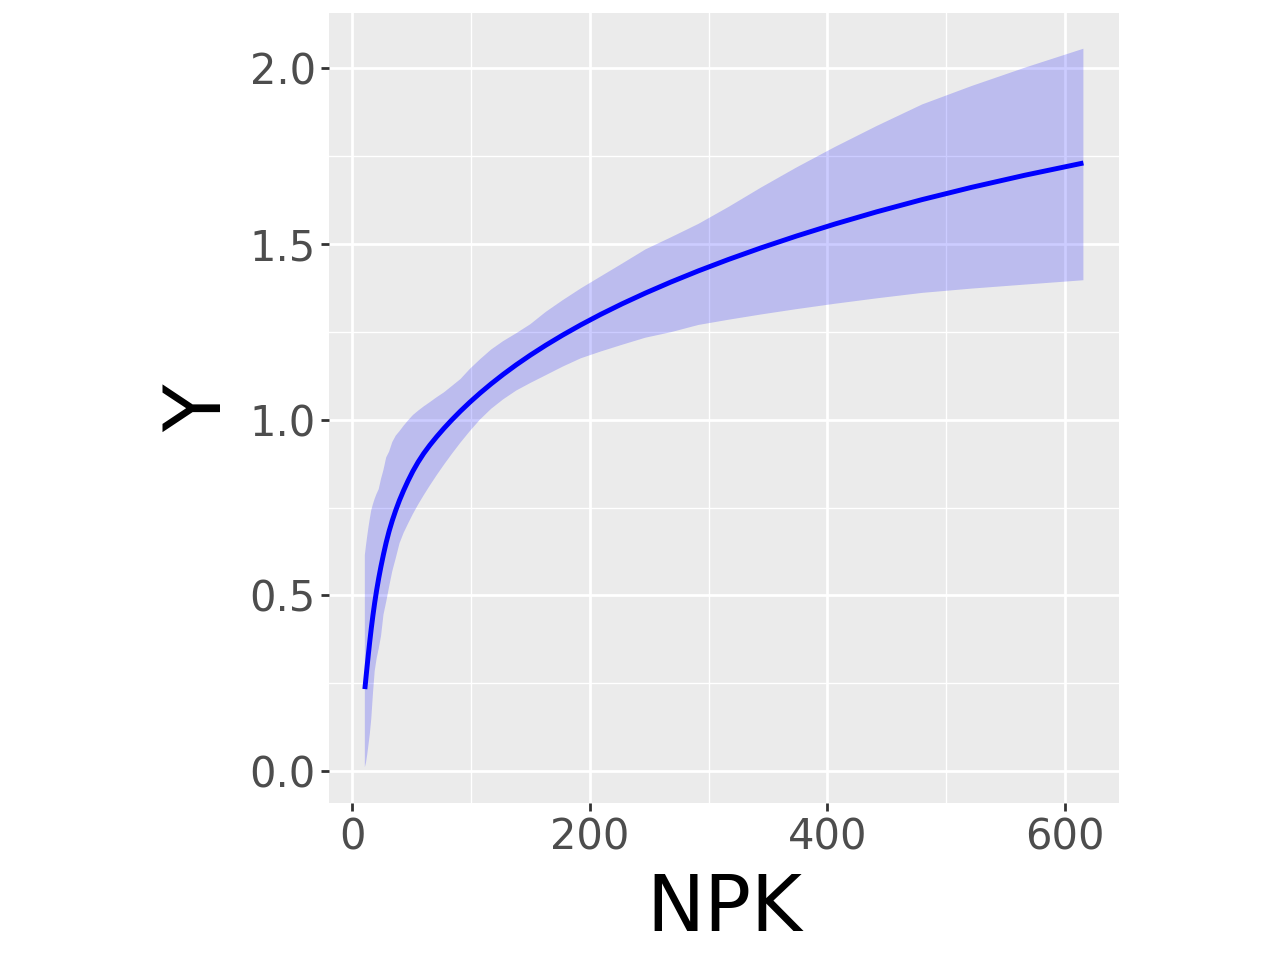

/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: NPK_PDP_CI_NNfit_CELU.png


In [36]:
feature_idx = 2  # Feature: NPK
feature_values, pdp_mean, pdp_lower, pdp_upper = partial_dependence_ci(
    x_tensor, y, feature_idx=feature_idx, B=100,
    hidden_sizes=[32,16], activation_fun=wosd.FlippedLeakRELU(alpha=0.08),
    sigma_v=0.188, sigma_u=0.13, lr=0.01, epochs=1000
)

# Convert feature and PDP back to original scale
x2_mean, x2_std = np.mean(np.log(np.array(loaded_dict['NPK']))), np.std(np.log(np.array(loaded_dict['NPK'])))
feature_original = np.exp(feature_values * x2_std + x2_mean)

pdp_mean_exp = np.exp(pdp_mean)
pdp_lower_exp = np.exp(pdp_lower)
pdp_upper_exp = np.exp(pdp_upper)

pdp_df = pd.DataFrame({
    'NPK': feature_original,
    'PDP_Mean': pdp_mean_exp,
    'PDP_Lower': pdp_lower_exp,
    'PDP_Upper': pdp_upper_exp
})

plot_npk = (
    ggplot(pdp_df) +
    geom_line(aes(x='NPK', y='PDP_Mean'), size=1, color='blue') +
    geom_ribbon(aes(x='NPK', ymin='PDP_Lower', ymax='PDP_Upper'), alpha=0.2, fill='blue') +
    labs(x='NPK', y='Y') +
    theme(
        legend_position=(0.97, 0.1),
        aspect_ratio=1,
        axis_text=element_text(size=15),
        axis_title=element_text(size=28)
    )
)
plot_npk.show()
plot_npk.save("NPK_PDP_CI_NNfit_CELU.png", width=8, height=6, dpi=300)